# Solving a multitraces formulation problem coupled with ordinary differential equations

Code considerations:
- We try to use numpy arrays for faster computations whenever it is possible (lists are very slow).

Import of the numpy library:

In [161]:
import numpy as np

Here we solve an example associated with the electropermeabilization problem. See article [Cell Electropermeabilization Modeling via Multiple Traces Formulation and Time Semi-Implicit Coupling](https://arxiv.org/abs/2403.19371) where the model and formulation are described. In this notebook we present other coupled models too.

## One sphere

We assume that the center of the sphere is in the origin.

### Parameters set up.

First, we set up the parameters of the problem:

#### Geometry and physical parameters

Radius of the sphere. It has to be a float number:

In [162]:
radius = 1.

The variable `sigmas` is a numpy array with the medium conductivities in the order $\sigma_0$, $\sigma_1$. The numbers have to be floats:

In [163]:
sigma_e = 15.  # 5 # extracellular conductivity, [microS / micro m]
sigma_i = 1.5  # 0.455  # intracellular conductivity, [microS / micro m]
sigmas = np.asarray([sigma_e, sigma_i])

Capacitance of the membrane (needs to be a float):

In [164]:
c_m = 1. # For FitzHugh-Nagumo
# c_m = 9.5*10**(-3)  # [p F / (micro m) ** 2] (This unit is for the Kavian et al. problem)

#### Discretization parameters

Maximum degree of the spherical harmonics to be used for discretize ($L$). It has to be an integer:

In [165]:
big_l = 10

Maximum degree of the spherical harmonics to be used for quadratures ($L_c$). It has to be an integer:

In [166]:
big_l_c = 30

Parameters for the time scheme used:

In [167]:
initial_time = 0.
final_time = 10.
number_steps = 2**14

#### Initial conditions

Set up of initial conditions, for this model we need two arrays of length `(big_l + 1)**2`. Each array has the coefficients of the spherical harmonic expansion of each initial condition.
In the following we give a couple of examples for building one of the arrays:

In [168]:
# Initial condition equal to zero
v_0_zero = np.zeros(((big_l+1)**2))
# Intial condition equal to a cte value
cte = 4.
v_0_cte_value = np.zeros(((big_l+1)**2))
v_0_cte_value[0] = cte * 2* np.sqrt(np.pi)

In this example we use initial conditions equal to zero. We need to set up both arrays in one:

In [169]:
initial_conditions = np.zeros((2, (big_l+1)**2))

#### Set up of the external excitation

Set up the contributions to the right hand side made by $\phi_e$. For this, we set up a function only dependent on time, to account for changes in time. In the module `biosspheres.formulations.mtf.timecouplings.righthands` there are implementations on how to do this, we use one of the pre-defined functions:

In [170]:
# Import of the module where pre-defined right hand sides are.
import biosspheres.formulations.mtf.timecouplings.righthands as righthands
# phi_e cte in time and space
cte=3.
phi_cte_space_time = righthands.phi_part_of_b_cte_space_and_time(
	big_l, n=1, radii=np.asarray([radius]), cte=cte
)
# phi_e point source in space, cte in time
phi_point_source_space_cte_time = righthands.phi_part_of_b_point_source_space_and_cte_time(
  big_l, n=1, radii=np.asarray([radius]), center_positions=[np.zeros((3))], p0 = 25.*np.ones((3)),
  sigma_e = sigmas[0], pii = np.asarray([sigmas[1]/sigmas[0]]), amplitude = 1.
)
# phi_e = cte * z_coordinate
phi_point_source_linear = righthands.phi_part_of_b_linear_space_z_cte_time(
  big_l, n=1, radii=np.asarray([radius]), center_positions=[np.zeros((3))],cte=cte, pii = np.asarray([sigmas[1]/sigmas[0]]))
# Which we are using:
b_phi_part_time_function = phi_point_source_linear

#### Parameters for the coupled currents and ordinary differential equations:

For a non-linear current following FitzHugh-Nagumo dynamics:

In [171]:
parameter_theta = 0.8 # must be a float, adimensional parameter
parameter_b = 0.7     # must be a float, adimensional parameter
parameter_a = 0.3     # must be a float, adimensional parameter

For Kavian et al. dynamics:

In [172]:
s_l = 1.9*10**(-6)  # [micro S / (micro m) ** 2]
s_ir = 2.5*10**2  # [micro S / (micro m) ** 2]
tau_ep = 1.  # [micro s]
tau_res = 10.**3  # [micro s]
k_ep = 40.  # [V ** -1]
v_rev = 1.5  # [V]

### Set up of internals

Set up of the time steps:

In [173]:
import biosspheres.formulations.mtf.timecouplings.solvertemplates as solve
tau, times, medium_times = solve.tau_times_medium(
	initial_time, final_time, number_steps
)

### Set up of the coupled problem

Set up of the non linear current. Different models for the current can be used, there are models ready to use in the module `biosspheres.miscella.forcouplings.currents`. See the internals of the module for making custom made currents.

In [174]:
import biosspheres.miscella.forcouplings.currents as currents

Some of the models that are in the module `import biosspheres.miscella.forcouplings.currents as currents` are presented now:

FitzHugh-Nagumo current:

In [175]:
i_current_fitzhughnagumo = currents.i_fitzhughnagumo_one_sphere_function_creation(
	big_l,
  big_l_c,
  radius
)

Set up of the semi-implicit scheme for the "gating" variables (or similar)

In [176]:
import biosspheres.miscella.forcouplings.oderesolutions as oderesolutions
ode_next_sol_fitzhugh = (
	oderesolutions.semi_implicit_fitzhughnagumo_one_sphere_next_step(
		tau, parameter_theta, parameter_b, parameter_a
	)
)

Kavian et al. current:

In [177]:
i_current_kavian = currents.i_kavian_leguebe_ea_2014_1_sphere_2d(big_l, big_l_c, radius, s_l, s_ir)

In [178]:
ode_next_sol_kavian = oderesolutions.next_step_z_kavian_leguebe_ea_2014_2d(big_l, big_l_c, tau, tau_ep, tau_res, k_ep, v_rev)

Here we choose the model to be used:

In [179]:
# i_current = i_current_fitzhughnagumo
# ode_next_sol = ode_next_sol_fitzhugh
i_current = i_current_kavian
ode_next_sol = ode_next_sol_kavian

### Solving

First, we set up internal parameters used for requirements of numpy for threading:

In [180]:
import os
number = "7" # Maximum of threads
os.environ["OMP_NUM_THREADS"] = number
os.environ["OPENBLAS_NUM_THREADS"] = number
os.environ["MKL_NUM_THREADS"] = number
os.environ["VECLIB_MAXIMUM_THREADS"] = number
os.environ["NUMEXPR_NUM_THREADS"] = number

We implemented a direct solver (LU decomposition) that takes as parameters what we previously defined, including the current and the coupled ODE system. The complete list can be seen in the following:

In [181]:
solutions = solve.mtf_time_coupling_one_sphere(
	big_l,
	radius,
	sigmas,
	c_m,
	initial_time,
	final_time,
	number_steps,
	initial_conditions,
	b_phi_part_time_function,
	i_current,
	ode_next_sol,
)

Notice that the functions is defined in the module `biosspheres.formulations.mtf.timecouplings.solvertemplates` shortened in `solve`

EXPLICAR EL FORMATO DE LA SOLUCION

### Saving the results

The following saves all solutions, i.e. traces, transmembrane potential, and recovery variables, in numpy format. We have commented the line for the saving.

In [182]:
filename="example.npy"
directory=""
# np.save(directory+filename, solutions)

To load the solutions:

In [183]:
# solutions = np.load(directory+filename)

To save in `txt` format:

In [184]:
filename="example.txt"
directory=""
# np.savetxt(directory+filename, solutions)

To load the solutions:

In [185]:
# solutions = np.loadtxt(directory+filename)

### Plotting the results

For plotting the evolution of time of the solutions evaluated in the north pole of the sphere:

Text(0.5, 1.0, 'v')

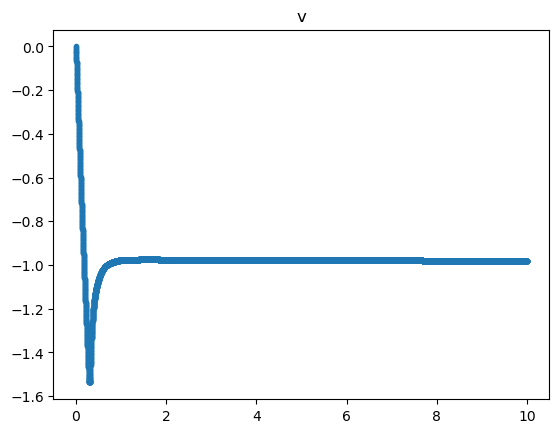

In [186]:
import matplotlib.pyplot as plt
# Auxiliary arrays for plotting
import biosspheres.utils.auxindexes as auxindexes
num = (big_l + 1)**2
eles, l_square_plus_l, el_square_plus_el_divided_by_two = (
        auxindexes.eles_combination(big_l)
    )
little_partial_spherical = np.sqrt((2 * eles + 1))
plt.figure()
plt.plot(
	times,
	np.sum(
		solutions[:, (4 * num + l_square_plus_l[0 : big_l + 1])]
		* little_partial_spherical[0 : big_l + 1],
		axis=1,
	)
	/ (2.0 * np.sqrt(np.pi)),
	label="Numerical solution",
	marker=".",
)
plt.title("v")

Text(0.5, 1.0, 'Additional variable')

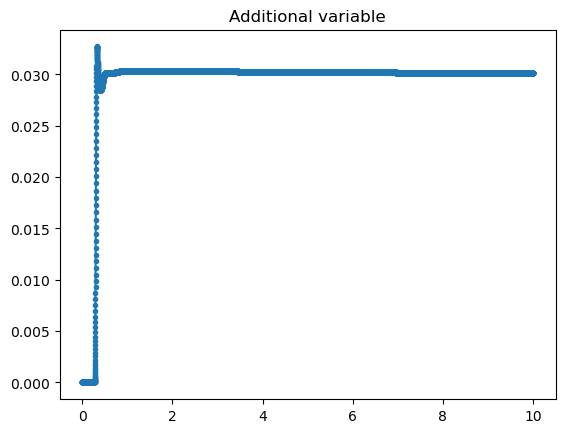

In [187]:
plt.figure()
little_partial_spherical = np.sqrt((2 * eles + 1))
plt.plot(
	times,
	np.sum(
		solutions[:, (5 * num + l_square_plus_l[0 : big_l + 1])]
		* little_partial_spherical[0 : big_l + 1],
		axis=1,
	)
	/ (2.0 * np.sqrt(np.pi)),
	label="Numerical solution",
	marker=".",
)
plt.title("Additional variable")

For plotting the transmembrane potential on the surface of the sphere at a given time:

In [188]:
# Auxiliary arrays
import biosspheres.quadratures.sphere as quadratures
(
	quantity_theta_points,
	quantity_phi_points,
	weights,
	pre_vector,
	spherical_harmonics,
) = quadratures.gauss_legendre_trapezoidal_real_sh_mapping_2d(
	big_l, big_l_c
)

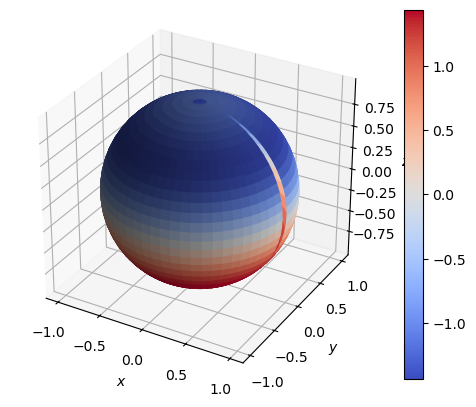

In [189]:
time_index = number_steps // 2  # half of the simulation 
vector = pre_vector * radius
surface_v = np.zeros((quantity_theta_points, quantity_phi_points))
surface_v[:, :] = np.sum(
	solutions[time_index, 4 * num:5*num, np.newaxis, np.newaxis]
	* spherical_harmonics, axis=0)
surface_v_max = np.max(np.abs(surface_v))
surface_v = (surface_v + surface_v_max) / (2. * surface_v_max)

from matplotlib import cm, colors
fig = plt.figure()
ax_1 = fig.add_subplot(111, projection='3d')
ax_1.plot_surface(
	vector[0, :, :],
	vector[1, :, :],
	vector[2, :, :],
	rstride=1, cstride=1, 
	facecolors=cm.coolwarm(surface_v[:, :]))
ax_1.set_xlabel('$x$')
ax_1.set_ylabel('$y$')
ax_1.set_zlabel('$z$')
ax_1.set_aspect('equal')
fig.colorbar(cm.ScalarMappable(
    norm=colors.CenteredNorm(halfrange=surface_v_max), cmap=cm.coolwarm),
    ax=ax_1)

That can be made a video too.

For plotting a plane cut without $\phi_e$:

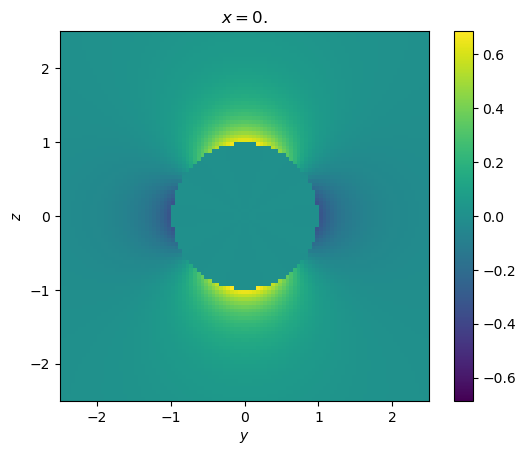

In [190]:
import biosspheres.laplace.drawing as draw
from matplotlib import cm, colors
cut = 1
# Size of the window to be plotted
horizontal = 5.
vertical = 5.
# For the resolution of the plot
inter_horizontal = 100
inter_vertical = 100
# For plotting without the external function we make the following function
def zero(x: np.ndarray) -> float:
    return 0.

x1, y1, data = draw.draw_cut_representation_formula_one_sphere_azimuthal_symmetry(
    cut, np.zeros((3)), horizontal, vertical, inter_horizontal, inter_vertical, solutions[time_index, 0 : 4 * num], radius, big_l, zero)
plt.figure()
plt.imshow(data, origin='lower',
           extent=[-horizontal / 2, horizontal / 2,
                   -vertical / 2, vertical / 2],
           norm=colors.CenteredNorm()
           )
plt.xlabel('$y$')
plt.ylabel('$z$')
plt.title('$x = 0.$')
plt.colorbar()